## Search Algorithms

So far we have been using Ray's basic/default Variant Generator in order to perform either:

 - Grid Search
 - Random Search
 
However, Raytune has an expanding suite of options available for different [Search Algortihms](https://docs.ray.io/en/latest/tune-searchalg.html):

 - BayesOpt
 - HyperOpt
 - SigOpt
 - Nevergrad
 - Scikit-Optimize
 - Ax
 - BOHB
 
These bolt in functionality from other well known libraries and make them avilable to us in Raytune. 

Depending on the library that we use there are some customisations needed to use it but these are not in our training code, but centered around how we define the `search space` and call `ray.run`.

### Switch to Bayesian Optimisation

Ray's BayesOpt uses the [bayesian-optimisation](https://github.com/fmfn/BayesianOptimization) package which is already installed in our conda environment





In [1]:
%load_ext autoreload
%autoreload 2

from dependencies import *
from seg_setup_code import *

Loading dependencies we have already seen...
Importing ray...
Done...


Rather than loading bayesopt directly we pull in the tune search algorithm tha wraps it

In [2]:
from ray.tune.suggest.bayesopt import BayesOptSearch

Next we have copied across the same training function from earlier notebooks.

In [3]:
from sklearn.model_selection import LeavePGroupsOut
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from scipy.signal import medfilt
from filelock import FileLock

def e2e_train_and_test(config, **kwargs):
    
    # threadsafe
#     with FileLock("./data.lock"):
    X, y, groups, X_test, y_test, group_test, well_names = setup(kwargs['filepath'])
    
    # chose your CV strategy
    splitter = LeavePGroupsOut(1)
    
    # run k fold training and validation
    f1_scores = [] # keep hold of all individual scores
    for train_ind, val_ind in splitter.split(X, y, groups=groups):
        pipeline = make_pipeline(RobustScaler(),
                                  XGBClassifier())

        pipeline.set_params(**config)
        pipeline.fit(X[train_ind], y[train_ind])
        
        y_pred = pipeline.predict(X[val_ind])
        
        f1_scores.append(f1_score(y_pred, y[val_ind], average='micro'))
    
        # Clean isolated facies for each well
        y_pred = medfilt(y_pred, kernel_size=5)
    
    # use tunes reporter
    tune.track.log(mean_f1_score=np.array(f1_scores).mean(),
                std_f1_score=np.array(f1_scores).std(),
                # and we can actually add any metrics we like
                done=True)

#### Defining the Search Space

In previous examples we have creates the search space for our tuning job using Raytune's distribution functions.

In [4]:
ray_tuning_config = {
    'xgbclassifier__learning_rate': tune.loguniform(0.001, 0.5),
    'xgbclassifier__max_depth': tune.randint(1, 10),
    'xgbclassifier__min_child_weight': tune.loguniform(0.1, 10),
    'xgbclassifier__n_estimators': tune.randint(5,200),
    'xgbclassifier__colsample_bytree': tune.choice([0.4, 0.6, 0.8, 1.0]),
    'xgbclassifier__lambda': tune.choice([0,1]),
    'xgbclassifier__seed': 42
}

But when using BayesOpt we need to change this and specify:
 - the bounds of the parameter space `pbounds`
 - the form / parameters of a UtilityFunction
 - a modified config object
 
To start with we convert our tuning config to align with pbounds, which uses simple tuples and only suppports *continuous* spaces

In [5]:
pbounds = {
    "xgbclassifier__learning_rate": (0.001, 0.5),
    "xgbclassifier__max_depth": (1, 10),                # Needs to be discrete!
    "xgbclassifier__min_child_weight": (0.1, 100),
    "xgbclassifier__n_estimators": (5, 200),            # Needs to be discrete!
    "xgbclassifier__colsample_bytree": (0.4, 1.0),
    "xgbclassifier__lambda": (0, 1)                     # Needs to be true/false 1/0
}

def parse_config(config):
    config["xgbclassifier__max_depth"] = int(round(config["xgbclassifier__max_depth"]))
    config["xgbclassifier__n_estimators"] = int(round(config["xgbclassifier__n_estimators"]))
    config["xgbclassifier__lambda"] = int(round(config["xgbclassifier__lambda"]))
    return config

In [6]:
utility_fn_kwargs={
    "kind": "ucb",
    "kappa": 2.5,
    "xi": 0.0
}

In [7]:
search_algo = BayesOptSearch(
                pbounds,
                metric="mean_f1_score",
                mode="max",
                utility_kwargs=utility_fn_kwargs)

In [13]:
config = {
    # controls the number of trials
    "num_samples": 10,
    "config": {
        "xgbclassifier__seed": 42,
    },
    "stop": {
        "timesteps_total": 4
    }
}

In [14]:
ray.shutdown()
ray.init(num_cpus=6, num_gpus=0, include_webui=True)

2020-06-11 22:49:09,672	INFO resource_spec.py:204 -- Starting Ray with 4.98 GiB memory available for workers and up to 2.5 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-06-11 22:49:09,934	INFO services.py:1168 -- View the Ray dashboard at localhost:8265


{'node_ip_address': '192.168.1.39',
 'raylet_ip_address': '192.168.1.39',
 'redis_address': '192.168.1.39:14007',
 'object_store_address': '/tmp/ray/session_2020-06-11_22-49-09_658322_14585/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2020-06-11_22-49-09_658322_14585/sockets/raylet',
 'webui_url': 'localhost:8265',
 'session_dir': '/tmp/ray/session_2020-06-11_22-49-09_658322_14585'}

In [15]:
from os import path
filepath = path.abspath('../datasets/seg_2016_facies/la_team_5_data.h5py')

def e2e_seg(config):
    return e2e_train_and_test(config, filepath=filepath)

def e2e_seg_w_discrete(config):  
    return e2e_seg(
        parse_config(config)
    )

analysis = tune.run(e2e_seg_w_discrete,
                    name="seg_facies_bayes",
                    search_alg=search_algo,
                    **config)

Trial name,status,loc,xgbclassifier__colsample_bytree,xgbclassifier__lambda,xgbclassifier__learning_rate,xgbclassifier__max_depth,xgbclassifier__min_child_weight,xgbclassifier__n_estimators
e2e_seg_w_discrete_61ffa7d6,RUNNING,,0.861933,0.614533,0.256903,5.39107,4.66088,108.991
e2e_seg_w_discrete_620ca0da,PENDING,,0.856036,0.0210607,0.5,10,55.0355,132.211
e2e_seg_w_discrete_626068d2,PENDING,,0.440468,0.910661,0.103885,9.94146,32.4363,140.828
e2e_seg_w_discrete_6264fd70,PENDING,,0.574219,0.441525,0.5,10,55.0415,132.213
e2e_seg_w_discrete_6282a3b6,PENDING,,0.473438,0.462313,0.140693,8.8947,54.9832,131.716
e2e_seg_w_discrete_62a3b330,PENDING,,0.626171,0.00981186,0.440864,2.24111,59.1465,142.802
e2e_seg_w_discrete_62a7beee,PENDING,,0.737673,0.379278,0.239421,5.24447,5.1977,110.304
e2e_seg_w_discrete_62abf2ca,PENDING,,0.694015,0.70216,0.250097,3.58001,4.92242,109.42
e2e_seg_w_discrete_62b26416,PENDING,,0.871195,0.363317,0.499625,4.47492,5.49826,110.551
e2e_seg_w_discrete_62ba1eb8,PENDING,,0.550949,0.21164,0.356636,3.68604,3.80426,109.463


(pid=15316) 2020-06-11 22:49:13,636	INFO trainable.py:217 -- Getting current IP.
(pid=15318) 2020-06-11 22:49:13,617	INFO trainable.py:217 -- Getting current IP.
(pid=15317) 2020-06-11 22:49:13,591	INFO trainable.py:217 -- Getting current IP.
(pid=15315) 2020-06-11 22:49:13,677	INFO trainable.py:217 -- Getting current IP.
(pid=15320) 2020-06-11 22:49:13,644	INFO trainable.py:217 -- Getting current IP.
(pid=15319) 2020-06-11 22:49:13,660	INFO trainable.py:217 -- Getting current IP.
Result for e2e_seg_w_discrete_62a3b330:
  date: 2020-06-11_22-49-54
  done: true
  experiment_id: 571238576d1441ff9d4f20bc68178f5d
  experiment_tag: 6_xgbclassifier__colsample_bytree=0.62617,xgbclassifier__lambda=0.0098119,xgbclassifier__learning_rate=0.44086,xgbclassifier__max_depth=2.2411,xgbclassifier__min_child_weight=59.147,xgbclassifier__n_estimators=142.8,xgbclassifier__seed=42
  hostname: Steves-MacBook-Pro.local
  iterations_since_restore: 1
  mean_f1_score: 0.5545115672145957
  node_ip: 192.168.1.39

Trial name,status,loc,xgbclassifier__colsample_bytree,xgbclassifier__lambda,xgbclassifier__learning_rate,xgbclassifier__max_depth,xgbclassifier__min_child_weight,xgbclassifier__n_estimators,iter,total time (s)
e2e_seg_w_discrete_61ffa7d6,RUNNING,,0.861933,0.614533,0.256903,5.39107,4.66088,108.991,,
e2e_seg_w_discrete_620ca0da,RUNNING,,0.856036,0.0210607,0.5,10,55.0355,132.211,,
e2e_seg_w_discrete_626068d2,RUNNING,,0.440468,0.910661,0.103885,9.94146,32.4363,140.828,,
e2e_seg_w_discrete_6264fd70,RUNNING,,0.574219,0.441525,0.5,10,55.0415,132.213,,
e2e_seg_w_discrete_6282a3b6,RUNNING,,0.473438,0.462313,0.140693,8.8947,54.9832,131.716,,
e2e_seg_w_discrete_62a3b330,TERMINATED,,0.626171,0.00981186,0.440864,2.24111,59.1465,142.802,0,40.977
e2e_seg_w_discrete_62a7beee,PENDING,,0.737673,0.379278,0.239421,5.24447,5.1977,110.304,,
e2e_seg_w_discrete_62abf2ca,PENDING,,0.694015,0.70216,0.250097,3.58001,4.92242,109.42,,
e2e_seg_w_discrete_62b26416,PENDING,,0.871195,0.363317,0.499625,4.47492,5.49826,110.551,,
e2e_seg_w_discrete_62ba1eb8,PENDING,,0.550949,0.21164,0.356636,3.68604,3.80426,109.463,,


(pid=15382) 2020-06-11 22:49:57,223	INFO trainable.py:217 -- Getting current IP.
Result for e2e_seg_w_discrete_6264fd70:
  date: 2020-06-11_22-50-13
  done: true
  experiment_id: 972c8c07d4214b6abb8bf4073db87cf9
  experiment_tag: 4_xgbclassifier__colsample_bytree=0.57422,xgbclassifier__lambda=0.44153,xgbclassifier__learning_rate=0.5,xgbclassifier__max_depth=10.0,xgbclassifier__min_child_weight=55.042,xgbclassifier__n_estimators=132.21,xgbclassifier__seed=42
  hostname: Steves-MacBook-Pro.local
  iterations_since_restore: 1
  mean_f1_score: 0.5622208643005723
  node_ip: 192.168.1.39
  pid: 15320
  std_f1_score: 0.07539848113616704
  time_since_restore: 60.24954915046692
  time_this_iter_s: 60.24954915046692
  time_total_s: 60.24954915046692
  timestamp: 1591912213
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: 6264fd70
  


Trial name,status,loc,xgbclassifier__colsample_bytree,xgbclassifier__lambda,xgbclassifier__learning_rate,xgbclassifier__max_depth,xgbclassifier__min_child_weight,xgbclassifier__n_estimators,iter,total time (s)
e2e_seg_w_discrete_61ffa7d6,RUNNING,,0.861933,0.614533,0.256903,5.39107,4.66088,108.991,,
e2e_seg_w_discrete_620ca0da,RUNNING,,0.856036,0.0210607,0.5,10,55.0355,132.211,,
e2e_seg_w_discrete_626068d2,RUNNING,,0.440468,0.910661,0.103885,9.94146,32.4363,140.828,,
e2e_seg_w_discrete_6264fd70,TERMINATED,,0.574219,0.441525,0.5,10,55.0415,132.213,0,60.2495
e2e_seg_w_discrete_6282a3b6,RUNNING,,0.473438,0.462313,0.140693,8.8947,54.9832,131.716,,
e2e_seg_w_discrete_62a3b330,TERMINATED,,0.626171,0.00981186,0.440864,2.24111,59.1465,142.802,0,40.977
e2e_seg_w_discrete_62a7beee,RUNNING,,0.737673,0.379278,0.239421,5.24447,5.1977,110.304,,
e2e_seg_w_discrete_62abf2ca,PENDING,,0.694015,0.70216,0.250097,3.58001,4.92242,109.42,,
e2e_seg_w_discrete_62b26416,PENDING,,0.871195,0.363317,0.499625,4.47492,5.49826,110.551,,
e2e_seg_w_discrete_62ba1eb8,PENDING,,0.550949,0.21164,0.356636,3.68604,3.80426,109.463,,


Result for e2e_seg_w_discrete_6282a3b6:
  date: 2020-06-11_22-50-15
  done: true
  experiment_id: 5e7a9bbeaf0043a5a32b236d4910b606
  experiment_tag: 5_xgbclassifier__colsample_bytree=0.47344,xgbclassifier__lambda=0.46231,xgbclassifier__learning_rate=0.14069,xgbclassifier__max_depth=8.8947,xgbclassifier__min_child_weight=54.983,xgbclassifier__n_estimators=131.72,xgbclassifier__seed=42
  hostname: Steves-MacBook-Pro.local
  iterations_since_restore: 1
  mean_f1_score: 0.5702927515745676
  node_ip: 192.168.1.39
  pid: 15319
  std_f1_score: 0.06130392604738035
  time_since_restore: 61.411617040634155
  time_this_iter_s: 61.411617040634155
  time_total_s: 61.411617040634155
  timestamp: 1591912215
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: 6282a3b6
  
(pid=15417) 2020-06-11 22:50:16,704	INFO trainable.py:217 -- Getting current IP.
(pid=15419) 2020-06-11 22:50:17,252	INFO trainable.py:217 -- Getting current IP.
Result for e2e_seg_w_discrete_626068d2:
  date: 2020-06-11_

Trial name,status,loc,xgbclassifier__colsample_bytree,xgbclassifier__lambda,xgbclassifier__learning_rate,xgbclassifier__max_depth,xgbclassifier__min_child_weight,xgbclassifier__n_estimators,iter,total time (s)
e2e_seg_w_discrete_61ffa7d6,RUNNING,,0.861933,0.614533,0.256903,5.39107,4.66088,108.991,,
e2e_seg_w_discrete_620ca0da,RUNNING,,0.856036,0.0210607,0.5,10,55.0355,132.211,,
e2e_seg_w_discrete_626068d2,TERMINATED,,0.440468,0.910661,0.103885,9.94146,32.4363,140.828,0,78.0656
e2e_seg_w_discrete_6264fd70,TERMINATED,,0.574219,0.441525,0.5,10,55.0415,132.213,0,60.2495
e2e_seg_w_discrete_6282a3b6,TERMINATED,,0.473438,0.462313,0.140693,8.8947,54.9832,131.716,0,61.4116
e2e_seg_w_discrete_62a3b330,TERMINATED,,0.626171,0.00981186,0.440864,2.24111,59.1465,142.802,0,40.977
e2e_seg_w_discrete_62a7beee,RUNNING,,0.737673,0.379278,0.239421,5.24447,5.1977,110.304,,
e2e_seg_w_discrete_62abf2ca,RUNNING,,0.694015,0.70216,0.250097,3.58001,4.92242,109.42,,
e2e_seg_w_discrete_62b26416,RUNNING,,0.871195,0.363317,0.499625,4.47492,5.49826,110.551,,
e2e_seg_w_discrete_62ba1eb8,PENDING,,0.550949,0.21164,0.356636,3.68604,3.80426,109.463,,


(pid=15440) 2020-06-11 22:50:33,787	INFO trainable.py:217 -- Getting current IP.
Result for e2e_seg_w_discrete_620ca0da:
  date: 2020-06-11_22-50-34
  done: true
  experiment_id: 31eb25e711b545b59dfcc017314f80ea
  experiment_tag: 2_xgbclassifier__colsample_bytree=0.85604,xgbclassifier__lambda=0.021061,xgbclassifier__learning_rate=0.5,xgbclassifier__max_depth=10.0,xgbclassifier__min_child_weight=55.035,xgbclassifier__n_estimators=132.21,xgbclassifier__seed=42
  hostname: Steves-MacBook-Pro.local
  iterations_since_restore: 1
  mean_f1_score: 0.5594310894812866
  node_ip: 192.168.1.39
  pid: 15316
  std_f1_score: 0.07066432529283886
  time_since_restore: 80.49796295166016
  time_this_iter_s: 80.49796295166016
  time_total_s: 80.49796295166016
  timestamp: 1591912234
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: 620ca0da
  
Result for e2e_seg_w_discrete_61ffa7d6:
  date: 2020-06-11_22-50-53
  done: true
  experiment_id: 12e2c7f9cc224b229f132a13be02c937
  experiment_tag:

Trial name,status,loc,xgbclassifier__colsample_bytree,xgbclassifier__lambda,xgbclassifier__learning_rate,xgbclassifier__max_depth,xgbclassifier__min_child_weight,xgbclassifier__n_estimators,iter,total time (s)
e2e_seg_w_discrete_61ffa7d6,TERMINATED,,0.861933,0.614533,0.256903,5.39107,4.66088,108.991,0,99.8036
e2e_seg_w_discrete_620ca0da,TERMINATED,,0.856036,0.0210607,0.5,10,55.0355,132.211,0,80.498
e2e_seg_w_discrete_626068d2,TERMINATED,,0.440468,0.910661,0.103885,9.94146,32.4363,140.828,0,78.0656
e2e_seg_w_discrete_6264fd70,TERMINATED,,0.574219,0.441525,0.5,10,55.0415,132.213,0,60.2495
e2e_seg_w_discrete_6282a3b6,TERMINATED,,0.473438,0.462313,0.140693,8.8947,54.9832,131.716,0,61.4116
e2e_seg_w_discrete_62a3b330,TERMINATED,,0.626171,0.00981186,0.440864,2.24111,59.1465,142.802,0,40.977
e2e_seg_w_discrete_62a7beee,RUNNING,,0.737673,0.379278,0.239421,5.24447,5.1977,110.304,,
e2e_seg_w_discrete_62abf2ca,RUNNING,,0.694015,0.70216,0.250097,3.58001,4.92242,109.42,,
e2e_seg_w_discrete_62b26416,RUNNING,,0.871195,0.363317,0.499625,4.47492,5.49826,110.551,,
e2e_seg_w_discrete_62ba1eb8,RUNNING,,0.550949,0.21164,0.356636,3.68604,3.80426,109.463,,


Result for e2e_seg_w_discrete_62abf2ca:
  date: 2020-06-11_22-51-15
  done: true
  experiment_id: a005b159b4ff4fd08eefa10ddc33dc62
  experiment_tag: 8_xgbclassifier__colsample_bytree=0.69401,xgbclassifier__lambda=0.70216,xgbclassifier__learning_rate=0.2501,xgbclassifier__max_depth=3.58,xgbclassifier__min_child_weight=4.9224,xgbclassifier__n_estimators=109.42,xgbclassifier__seed=42
  hostname: Steves-MacBook-Pro.local
  iterations_since_restore: 1
  mean_f1_score: 0.5736443804044369
  node_ip: 192.168.1.39
  pid: 15417
  std_f1_score: 0.0911875710025267
  time_since_restore: 59.18130087852478
  time_this_iter_s: 59.18130087852478
  time_total_s: 59.18130087852478
  timestamp: 1591912275
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: 62abf2ca
  


Trial name,status,loc,xgbclassifier__colsample_bytree,xgbclassifier__lambda,xgbclassifier__learning_rate,xgbclassifier__max_depth,xgbclassifier__min_child_weight,xgbclassifier__n_estimators,iter,total time (s)
e2e_seg_w_discrete_61ffa7d6,TERMINATED,,0.861933,0.614533,0.256903,5.39107,4.66088,108.991,0,99.8036
e2e_seg_w_discrete_620ca0da,TERMINATED,,0.856036,0.0210607,0.5,10,55.0355,132.211,0,80.498
e2e_seg_w_discrete_626068d2,TERMINATED,,0.440468,0.910661,0.103885,9.94146,32.4363,140.828,0,78.0656
e2e_seg_w_discrete_6264fd70,TERMINATED,,0.574219,0.441525,0.5,10,55.0415,132.213,0,60.2495
e2e_seg_w_discrete_6282a3b6,TERMINATED,,0.473438,0.462313,0.140693,8.8947,54.9832,131.716,0,61.4116
e2e_seg_w_discrete_62a3b330,TERMINATED,,0.626171,0.00981186,0.440864,2.24111,59.1465,142.802,0,40.977
e2e_seg_w_discrete_62a7beee,RUNNING,,0.737673,0.379278,0.239421,5.24447,5.1977,110.304,,
e2e_seg_w_discrete_62abf2ca,TERMINATED,,0.694015,0.70216,0.250097,3.58001,4.92242,109.42,0,59.1813
e2e_seg_w_discrete_62b26416,RUNNING,,0.871195,0.363317,0.499625,4.47492,5.49826,110.551,,
e2e_seg_w_discrete_62ba1eb8,RUNNING,,0.550949,0.21164,0.356636,3.68604,3.80426,109.463,,


Result for e2e_seg_w_discrete_62a7beee:
  date: 2020-06-11_22-51-16
  done: true
  experiment_id: f9d20df93ed744e1801158e6ccc17d27
  experiment_tag: 7_xgbclassifier__colsample_bytree=0.73767,xgbclassifier__lambda=0.37928,xgbclassifier__learning_rate=0.23942,xgbclassifier__max_depth=5.2445,xgbclassifier__min_child_weight=5.1977,xgbclassifier__n_estimators=110.3,xgbclassifier__seed=42
  hostname: Steves-MacBook-Pro.local
  iterations_since_restore: 1
  mean_f1_score: 0.5822019584330782
  node_ip: 192.168.1.39
  pid: 15382
  std_f1_score: 0.08708684127439008
  time_since_restore: 79.02609419822693
  time_this_iter_s: 79.02609419822693
  time_total_s: 79.02609419822693
  timestamp: 1591912276
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: 62a7beee
  
Result for e2e_seg_w_discrete_62ba1eb8:
  date: 2020-06-11_22-51-18
  done: true
  experiment_id: 1ae0c508269842c6929615dc56a31343
  experiment_tag: 10_xgbclassifier__colsample_bytree=0.55095,xgbclassifier__lambda=0.21164,xgb

Trial name,status,loc,xgbclassifier__colsample_bytree,xgbclassifier__lambda,xgbclassifier__learning_rate,xgbclassifier__max_depth,xgbclassifier__min_child_weight,xgbclassifier__n_estimators,iter,total time (s)
e2e_seg_w_discrete_61ffa7d6,TERMINATED,,0.861933,0.614533,0.256903,5.39107,4.66088,108.991,0,99.8036
e2e_seg_w_discrete_620ca0da,TERMINATED,,0.856036,0.0210607,0.5,10,55.0355,132.211,0,80.498
e2e_seg_w_discrete_626068d2,TERMINATED,,0.440468,0.910661,0.103885,9.94146,32.4363,140.828,0,78.0656
e2e_seg_w_discrete_6264fd70,TERMINATED,,0.574219,0.441525,0.5,10,55.0415,132.213,0,60.2495
e2e_seg_w_discrete_6282a3b6,TERMINATED,,0.473438,0.462313,0.140693,8.8947,54.9832,131.716,0,61.4116
e2e_seg_w_discrete_62a3b330,TERMINATED,,0.626171,0.00981186,0.440864,2.24111,59.1465,142.802,0,40.977
e2e_seg_w_discrete_62a7beee,TERMINATED,,0.737673,0.379278,0.239421,5.24447,5.1977,110.304,0,79.0261
e2e_seg_w_discrete_62abf2ca,TERMINATED,,0.694015,0.70216,0.250097,3.58001,4.92242,109.42,0,59.1813
e2e_seg_w_discrete_62b26416,TERMINATED,,0.871195,0.363317,0.499625,4.47492,5.49826,110.551,0,66.0485
e2e_seg_w_discrete_62ba1eb8,TERMINATED,,0.550949,0.21164,0.356636,3.68604,3.80426,109.463,0,44.5499


Trial name,status,loc,xgbclassifier__colsample_bytree,xgbclassifier__lambda,xgbclassifier__learning_rate,xgbclassifier__max_depth,xgbclassifier__min_child_weight,xgbclassifier__n_estimators,iter,total time (s)
e2e_seg_w_discrete_61ffa7d6,TERMINATED,,0.861933,0.614533,0.256903,5.39107,4.66088,108.991,0,99.8036
e2e_seg_w_discrete_620ca0da,TERMINATED,,0.856036,0.0210607,0.5,10,55.0355,132.211,0,80.498
e2e_seg_w_discrete_626068d2,TERMINATED,,0.440468,0.910661,0.103885,9.94146,32.4363,140.828,0,78.0656
e2e_seg_w_discrete_6264fd70,TERMINATED,,0.574219,0.441525,0.5,10,55.0415,132.213,0,60.2495
e2e_seg_w_discrete_6282a3b6,TERMINATED,,0.473438,0.462313,0.140693,8.8947,54.9832,131.716,0,61.4116
e2e_seg_w_discrete_62a3b330,TERMINATED,,0.626171,0.00981186,0.440864,2.24111,59.1465,142.802,0,40.977
e2e_seg_w_discrete_62a7beee,TERMINATED,,0.737673,0.379278,0.239421,5.24447,5.1977,110.304,0,79.0261
e2e_seg_w_discrete_62abf2ca,TERMINATED,,0.694015,0.70216,0.250097,3.58001,4.92242,109.42,0,59.1813
e2e_seg_w_discrete_62b26416,TERMINATED,,0.871195,0.363317,0.499625,4.47492,5.49826,110.551,0,66.0485
e2e_seg_w_discrete_62ba1eb8,TERMINATED,,0.550949,0.21164,0.356636,3.68604,3.80426,109.463,0,44.5499


In [16]:
from pprint import pprint
print("Best config: ")
pprint(analysis.get_best_config(metric="mean_f1_score"))

Best config: 
{'xgbclassifier__colsample_bytree': 0.7376730011283614,
 'xgbclassifier__lambda': 0.37927811689817226,
 'xgbclassifier__learning_rate': 0.23942070438712235,
 'xgbclassifier__max_depth': 5.244469831509153,
 'xgbclassifier__min_child_weight': 5.197701774637829,
 'xgbclassifier__n_estimators': 110.30376354864264,
 'xgbclassifier__seed': 42}


In [17]:
df = analysis.dataframe()
top_n_df = df.nlargest(10, "mean_f1_score")

In [18]:
top_n_df.head()

,mean_f1_score,std_f1_score,done,trial_id,training_iteration,time_this_iter_s,timesteps_total,episodes_total,experiment_id,date,...,iterations_since_restore,experiment_tag,config/xgbclassifier__colsample_bytree,config/xgbclassifier__lambda,config/xgbclassifier__learning_rate,config/xgbclassifier__max_depth,config/xgbclassifier__min_child_weight,config/xgbclassifier__n_estimators,config/xgbclassifier__seed,logdir
6,0.582202,0.087087,True,62a7beee,0,79.026094,NaN,NaN,f9d20df93ed744e1801158e6ccc17d27,2020-06-11_22-51-16,...,1,"7_xgbclassifier__colsample_bytree=0.73767,xgbc...",0.737673,0.379278,0.239421,5.244470,5.197702,110.303764,42,/Users/stevejpurves/ray_results/seg_facies_bay...
9,0.581359,0.089624,True,62ba1eb8,0,44.549882,NaN,NaN,1ae0c508269842c6929615dc56a31343,2020-06-11_22-51-18,...,1,"10_xgbclassifier__colsample_bytree=0.55095,xgb...",0.550949,0.211640,0.356636,3.686040,3.804257,109.463339,42,/Users/stevejpurves/ray_results/seg_facies_bay...
8,0.576639,0.094498,True,62b26416,0,66.048472,NaN,NaN,fdb8566664f94a74874f52690fbe0077,2020-06-11_22-51-23,...,1,"9_xgbclassifier__colsample_bytree=0.8712,xgbcl...",0.871195,0.363317,0.499625,4.474921,5.498263,110.550727,42,/Users/stevejpurves/ray_results/seg_facies_bay...
0,0.575526,0.087125,True,61ffa7d6,0,99.803590,NaN,NaN,12e2c7f9cc224b229f132a13be02c937,2020-06-11_22-50-53,...,1,"1_xgbclassifier__colsample_bytree=0.86193,xgbc...",0.861933,0.614533,0.256903,5.391066,4.660876,108.991473,42,/Users/stevejpurves/ray_results/seg_facies_bay...
7,0.573644,0.091188,True,62abf2ca,0,59.181301,NaN,NaN,a005b159b4ff4fd08eefa10ddc33dc62,2020-06-11_22-51-15,...,1,"8_xgbclassifier__colsample_bytree=0.69401,xgbc...",0.694015,0.702160,0.250097,3.580008,4.922417,109.420250,42,/Users/stevejpurves/ray_results/seg_facies_bay...


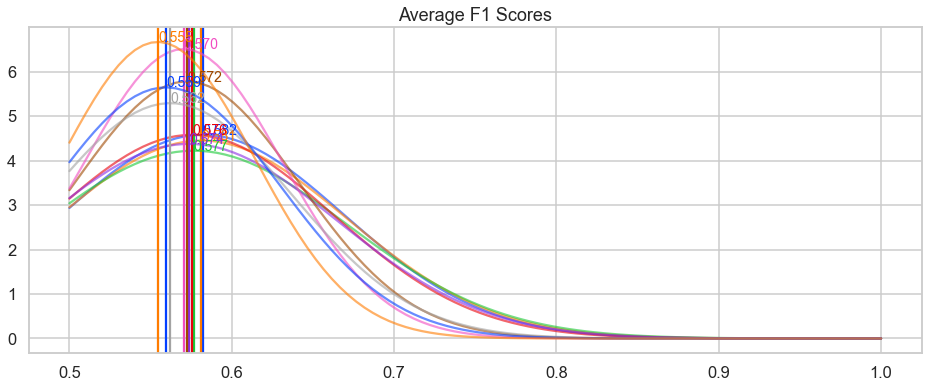

In [19]:
plot_some_tune_results(top_n_df, (0.5, 1.0))

In [29]:
param_cols = [
    'config/xgbclassifier__n_estimators',    
    'config/xgbclassifier__colsample_bytree',
    'config/xgbclassifier__lambda',
    'config/xgbclassifier__learning_rate',
    'config/xgbclassifier__max_depth',
    'config/xgbclassifier__min_child_weight',
]

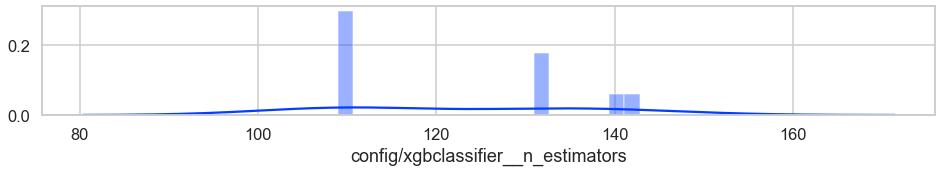

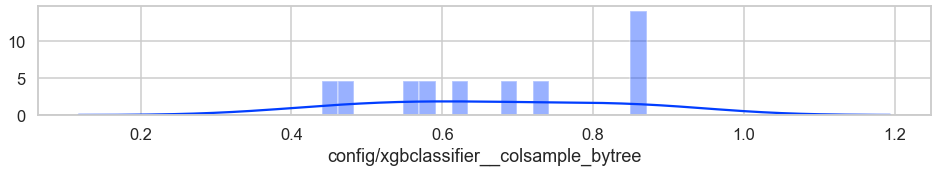

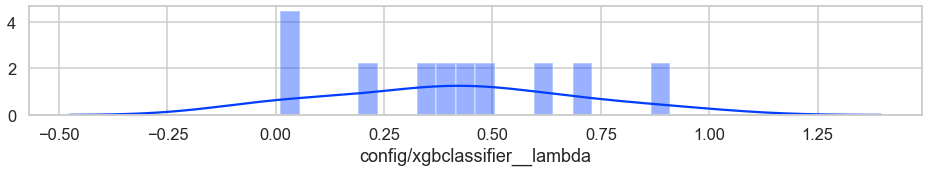

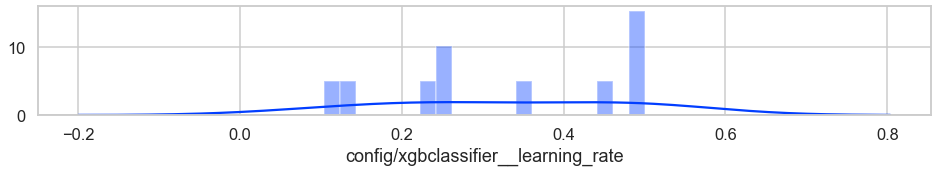

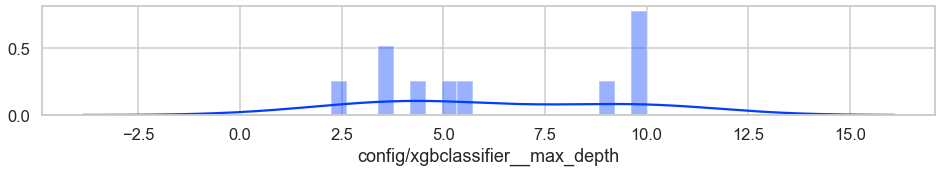

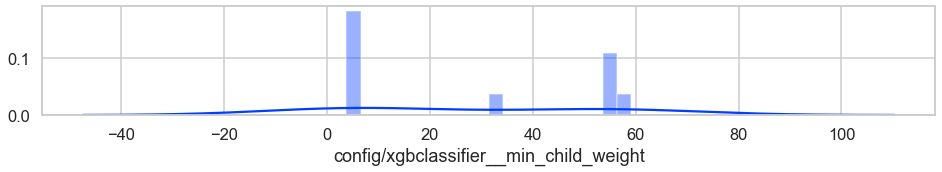

In [30]:
for col in param_cols:
    plt.figure(figsize=(16,2))
    sns.distplot(df[col], bins=20)
    

In [ ]:
%load_ext tensorboard
from tensorboard import notebook 
%tensorboard --logdir "~/ray_results/seg_facies"
notebook.display(height=1000)

In [ ]:
ray.shutdown()